*本节在 **倒立摆（Pendulum）连续-动作** 交互环境下进行 **PPO-Clip** 代码实践*

导入相关库：

In [1]:
# 基本库
import numpy as np
import copy

from utils.smoothing import moving_average
from utils.advantage import compute_advantage
from utils.training import train_on_policy_agent
# 神经网络
import torch
import torch.nn.functional as F
# Gymnasium 是一个用于开发和测试强化学习算法的工具库，为 OpenAI Gym 的更新版本（2021迁移开发）
import gymnasium as gym

## 倒立摆环境（'Pendulum-v1'）

### 价值网络（保持不变）:

In [2]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

### 策略网络：动作输出修改为高斯分布的均值和标准差

In [3]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std  # 高斯分布的均值和标准差，每一个状态对应一个高斯分布（多维）的均值和标准差

### 定义 PPO-Clip 算法（连续动作）：

In [4]:
class PPOContinuous:
    """ PPO-Clip（连续动作） """
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        #---------------------
        mu, std = self.actor(state)
        action_dist = torch.distributions.Normal(mu, std)
        #---------------------
        action = action_dist.sample()
        return [action.item()]  # 多维动作

    def update(self, transition_dict):
        states_np = np.array(transition_dict['states'])  # 转换成统一的大 np.ndarray，PyTorch更高效处理
        states = torch.tensor(states_np, dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states_np = np.array(transition_dict['next_states'])  # 转换成统一的大 np.ndarray，PyTorch更高效处理
        next_states = torch.tensor(next_states_np, dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        # rewards = (rewards + 16.0) / 16.0  # 标准归一化（线性映射到 [0, 1]）
        
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)  # 时序差分目标
        td_delta = td_target - self.critic(states)                                 # 时序差分误差
        
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        
        #------------------------------------------------
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        old_log_probs = action_dists.log_prob(actions)  # 动作是正态分布
        #-------------------------------------------------

        for _ in range(self.epochs):
            #-----------------------------------
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            #-----------------------------------
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

### 环境设置（'Pendulum-v1'）：

In [5]:
np.random.seed(0)    # 设置 NumPy 的随机种子
torch.manual_seed(0) # 设置 PyTorch CPU 随机种子
torch.cuda.manual_seed_all(0) # 设置 PyTorch GPU 随机种子, 由于GPU并行性, 只能极大减小偏差

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.reset(seed=0)   # 环境通常依赖于其他随机数生成器来初始化状态、进行探索(推荐位于以上随机之后)
print("Environment spec:", env.spec)

Environment spec: EnvSpec(id='Pendulum-v1', entry_point='gymnasium.envs.classic_control.pendulum:PendulumEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=200, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='Pendulum', version=1, additional_wrappers=(), vector_entry_point=None)


### 超参数设置：

In [6]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
hidden_dim = 128

lmbda = 0.9
eps = 0.2
actor_lr = 1e-4
critic_lr = 5e-3
gamma = 0.9
epochs = 10
device = torch.device("cuda") if torch.cuda.is_available() else torch.device( "cpu")
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

num_episodes = 2000

### 测试与训练:

In [7]:
return_list = train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 200/200 [01:06<00:00,  3.03it/s, episode=2000, return=-528.133]


### 绘图：

In [8]:
import pandas as pd
episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 9)
# 创建 DataFrame
df1 = pd.DataFrame({'Episodes': episodes_list, 'Returns': return_list})
df2 = pd.DataFrame({'Episodes': episodes_list, 'Returns': mv_return})
# 保存为 CSV 文件
df1.to_csv('PPO_Clip_Pendulum-v1_returns_data.csv', index=False)
df2.to_csv('PPO_Clip_Pendulum-v1_mv_returns_data.csv', index=False)

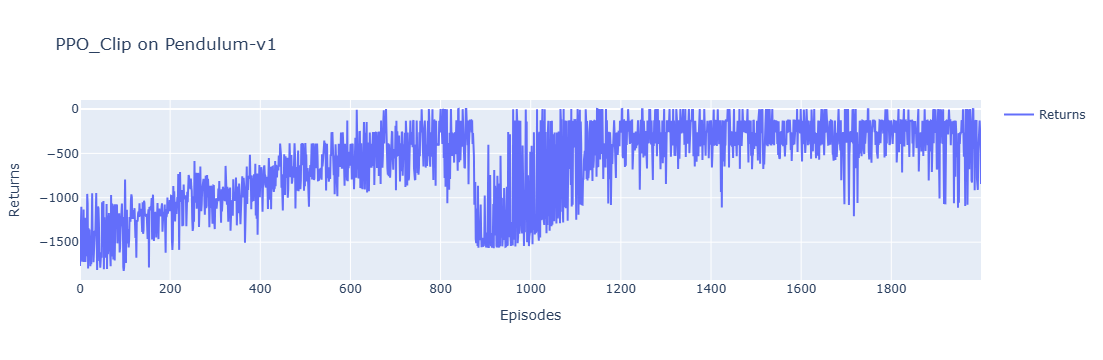

In [12]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('PPO_Clip_Pendulum-v1_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='PPO_Clip on Pendulum-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

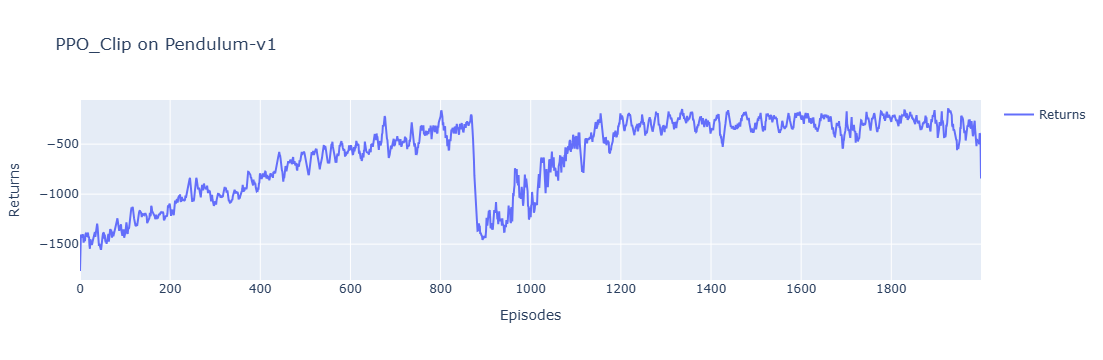

In [11]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('PPO_Clip_Pendulum-v1_mv_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='PPO_Clip on Pendulum-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

*可见，相较 **TRPO** 在 Pendulum-v1 环境下的表现，**PPO_Clip** 收敛更快，训练迭代的时间也更短*